# 8. Predict 2019 Crash Risks - (2014-2017 as training data) 

This notebook uses 2019 data as an example to demonstrate how to implement the models and interpret the modeling results. 

<a id='sections'></a>
**Sections**

- [**Predict 2019 Crash Risks - (2014-2017 as training data)**](#predict-2019-crash-risks)
    - [RuraL Area](#rural-area)
        - Binary Model
        - Multiclass Model
        - Binary Model + Multiclass Model
    - [Urban Area](#urban-area)  
        - Binary Model
        - Multiclass Model
        - Binary Model + Multiclass Model

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import pickle
from numpy import argmax
import importlib
import collections
import time
import getpass
import datetime as datetime
from shapely import wkt
from matplotlib import pyplot as plt

import categorical_embedder as ce
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer,  LabelEncoder
from sklearn.linear_model import LinearRegression,  LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE,SMOTENC
from imblearn.combine import SMOTEENN
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, brier_score_loss, auc
from sklearn.metrics import f1_score, fbeta_score, confusion_matrix, make_scorer, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import  StratifiedKFold, KFold, cross_val_score, StratifiedShuffleSplit
from sklearn.model_selection import  RepeatedStratifiedKFold, GridSearchCV, cross_validate
from sklearn import metrics
from xgboost import XGBClassifier

Using TensorFlow backend.
C:\Users\xl43843\Anaconda3\envs\geopandas\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\xl43843\Anaconda3\envs\geopandas\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\xl43843\Anaconda3\envs\geopandas\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\xl43843\Anaconda3\en

In [2]:
# import modules
import sys; sys.path.insert(0, '..')
import src.models
import src.multiclass_models
# importlib.reload (src.multiclass_models)
from src.models import *
from src.multiclass_models import *

In [3]:
base_gis_dir  = "G:/CUUATS/Safety Forecasting Tool/"
base_file_dir = "L:/Safety Forecasting Tool/"
base_tool_dir = "L:/Safety_Crash Data Analysis/"

In [4]:
from src.data_preprocessing import geo_segmentid
with open(base_file_dir+'data/interim/roadway/data_source/streets.pkl', 'rb') as f:
    streets = pickle.load(f)
# Project PCD roadway segments to epsg:3435
geo_SegmentID = geo_segmentid(streets)

# Rural Area
[[back to top](#sections)]
<a id='rural-area'></a>

In [5]:
with open(base_file_dir+'data/processed/df_rural_train_2014_2017.pkl', 'rb') as f:
    df_rural_train = pickle.load(f)
with open(base_file_dir+'data/processed/df_rural_train_label_2014_2017.pkl', 'rb') as f:
    df_rural_train_label = pickle.load(f)
with open(base_file_dir+'data/processed/df_rural_test_2019.pkl', 'rb') as f:
    df_rural_test_2019 = pickle.load(f)
with open(base_file_dir+'data/processed/df_rural_test_label_2019.pkl', 'rb') as f:
    df_rural_test_label_2019 = pickle.load(f)

In [6]:
# convert PC into a ordinal numeric field
df_rural_train=func_PC_numeric(df_rural_train)
df_rural_test=func_PC_numeric(df_rural_test_2019)
# Remove features that should not be fed into the model
remove_list=['segment_id','overlap','geometry','Year']
targetlist = [i for i in list(df_rural_train.columns) if i not in remove_list]
df_rural_train_sub = df_rural_train[targetlist]
df_rural_test_sub_2019 = df_rural_test[targetlist]

In [7]:
print(collections.Counter(df_rural_test_label_2019))
df_rural_test_binary_label_2019=df_rural_test_label_2019.mask(df_rural_test_label_2019 >= 1, 1)
print(collections.Counter(df_rural_test_binary_label_2019))
df_rural_test_cat_label_2019=df_rural_test_label_2019.mask(df_rural_test_label_2019 >= 3, 2)
print(collections.Counter(df_rural_test_cat_label_2019))

Counter({0.0: 5327, 1.0: 263, 2.0: 55, 3.0: 22, 4.0: 13, 5.0: 8, 6.0: 5, 7.0: 3, 9.0: 3, 19.0: 1, 13.0: 1, 10.0: 1, 15.0: 1, 8.0: 1})
Counter({0.0: 5327, 1.0: 377})
Counter({0.0: 5327, 1.0: 263, 2.0: 114})


In [8]:
X_train = df_rural_train_sub
X_test = df_rural_test_sub_2019
y_test_binary = df_rural_test_binary_label_2019
y_test_cat = df_rural_test_cat_label_2019

OHfname = func_OHtransformed_var(X_train)
X_test_OHtransformed=func_OHtransform_var(X_test)

In [9]:
class_weight = {'No Crash':0.2,'1 Crash':0.3,'>=2 Crashes':0.5}
target_names = list(class_weight.keys())

In [10]:
model_name = 'rural_binary_XGB_trainedw2014_2017_best_thres0.378.pkl'
with open(base_file_dir+'/models/segment/rural/binary/'+ model_name, 'rb') as f:
    rural_binary_xgb = pickle.load(f)
    
model_name = 'rural_multiclass_XGB_trainedw2014_2017.pkl'
with open(base_file_dir+'/models/segment/rural/multiclass/'+ model_name, 'rb') as f:
    rural_multiclass_xgb = pickle.load(f)    
    

## Binary Model
[[back to top](#sections)]

Interstate
          pred_neg  pred_pos
true_neg         5        37
true_pos         0        66
Local Road or Street
          pred_neg  pred_pos
true_neg      3939       487
true_pos        77        64
Major Arterial
          pred_neg  pred_pos
true_neg         3        37
true_pos         0        24
Major Collector
          pred_neg  pred_pos
true_neg       274       304
true_pos         9        82
Minor Arterial
          pred_neg  pred_pos
true_neg        38        72
true_pos         6        43
Minor Collector
          pred_neg  pred_pos
true_neg       105        26
true_pos         2         4
Overall
          pred_neg  pred_pos
true_neg      4364       963
true_pos        94       283
F2score: 0.51 Precision: 0.23 Recall: 0.75 Fpr: 0.18


f2score precision recall   fpr
Interstate               0.9      0.64    1.0  0.88
Local Road or Street    0.29      0.12   0.45  0.11
Major Arterial          0.76      0.39    1.0  0.92
Major Collector         0.55      0.21    0.9  0.53
Minor Arterial          0.69      0.37   0.88  0.65
Minor Collector         0.37      0.13   0.67   0.2
Overall                 0.51      0.23   0.75  0.18

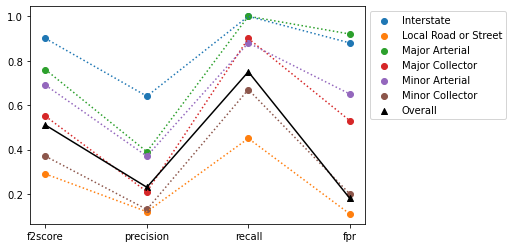

In [11]:
# Binary model prediction results
best_thres = 0.377818
y_test_pred_porba  = rural_binary_xgb.predict_proba(X_test_OHtransformed)[:,1]
Binary_y_pred = [1 if y>=best_thres else 0 for y in y_test_pred_porba]
cfm_fc(X_test, y_test_binary, Binary_y_pred)

Text(0.5, 1.0, 'rural_XGB-Binary_observed')

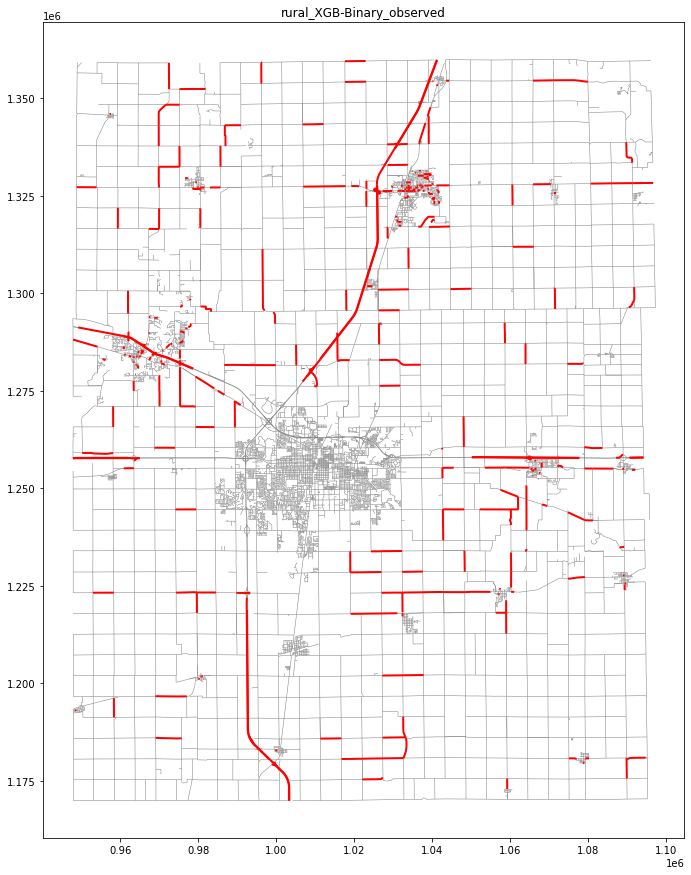

In [12]:
segment_intersection='segment'
model_geography='rural'
model_name = 'XGB-Binary'
map_name = model_geography+'_'+model_name+'_observed'
fig, ax = plt.subplots(figsize=(15,15))
test_geom = df_rural_test_2019.copy()
test_geom['Crashes'] = df_rural_test_label_2019
observed_crashes_binary_map (ax,test_geom,geo_SegmentID,2019)
plt.title(map_name)

TypeError: prediction_binary_maps() takes 5 positional arguments but 9 were given

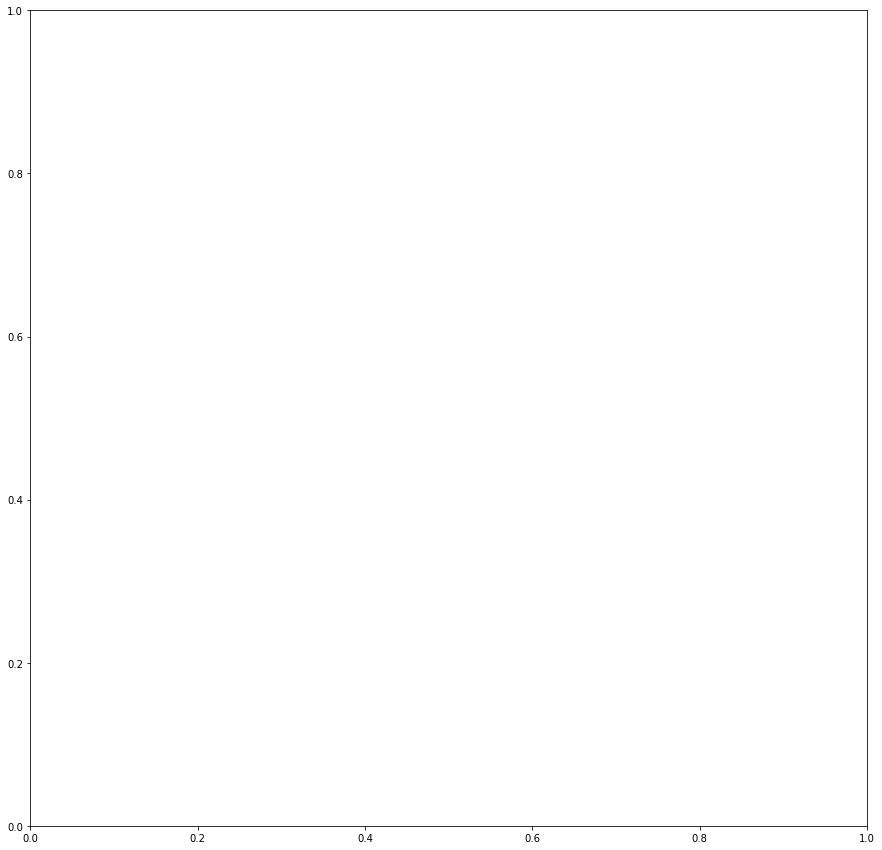

In [13]:
segment_intersection='segment'
model_geography='rural'
model_name = 'XGB-Binary'
map_name = model_geography+'_'+model_name+'_predicted'
fig, ax = plt.subplots(figsize=(15,15))
prediction_binary_maps (ax,geo_SegmentID, df_rural_test_2019, Binary_y_pred, 2019, 'segment','rural','XGB',map_name)
plt.title(map_name)

## Multi-class Model
[[back to top](#sections)]

In [ ]:
# Multiclass model prediction results
Multiclass_y_pred = rural_multiclass_xgb.predict(X_test_OHtransformed) 

print(metrics.confusion_matrix(df_rural_test_cat_label_2019, Multiclass_y_pred))
scoring_matrix = np.array([[1,-1,-2],[-3,2,-4],[-6,-5,3]])
wgt_cfm_score = np.sum(np.multiply(metrics.confusion_matrix(df_rural_test_cat_label_2019, Multiclass_y_pred),scoring_matrix))/np.sum(np.multiply(df_rural_test_cat_label_2019.value_counts().values,[1,2,3]))
print(wgt_cfm_score)
multiclass_perf_fullreport(df_rural_test_cat_label_2019, Multiclass_y_pred,class_weight)

In [ ]:
segment_intersection='segment'
model_geography='rural'
model_name = 'XGB-MultiClass'
map_name = model_geography+'_'+model_name+'_observed'
fig, axes = plt.subplots(figsize=(15,15))
plt_multiclass_observed_crashes_map (axes,df_rural_test,df_rural_test_cat_label_2019,2019)
plt.title(map_name)

In [ ]:
segment_intersection='segment'
model_geography='rural'
model_name = 'XGB-MultiClass'
map_name = model_geography+'_'+model_name+'_predicted'
fig, axes = plt.subplots(figsize=(15,15))
plt_multiclass_prediction_maps (axes, df_rural_test, Multiclass_y_pred, 2019)
plt.title(map_name)

## Binary Model + Multi-class Model
[[back to top](#sections)]

In [ ]:
BinaryMulticlass_results = df_rural_test.loc[:,['segment_id','geometry']].copy()
BinaryMulticlass_results['Binary'] = Binary_y_pred
BinaryMulticlass_results['MultiClass'] = Multiclass_y_pred

pd.crosstab(BinaryMulticlass_results['Binary'],BinaryMulticlass_results['MultiClass'])

In [ ]:
BinaryMulticlass_results

In [ ]:
print('Multiclass model classification results of roadways that are classified as class_0 by binary model:')
Binarypred_0 = [list(np.array(Binary_y_pred)==0)][0]

df = pd.DataFrame((metrics.confusion_matrix(y_test_cat.values[Binarypred_0], Multiclass_y_pred[Binarypred_0])))
df = df.rename(index={0: "True Class 0", 1: "True Class 1", 2: "True Class 2"})
df = df.rename(columns={0:"MultiPred Class 0",1:"MultiPred Class 1",2:"MultiPred Class 2"})
print(df)
print('\n')
real_counts_df = pd.DataFrame()
real_counts_df["crash_counts"] = df_rural_test_label_2019[Binarypred_0].values
real_counts_df["BinaryPred"] = 0
real_counts_df["MultiPred"] = Multiclass_y_pred[Binarypred_0]
real_counts_df = pd.DataFrame(real_counts_df.groupby(["crash_counts","BinaryPred","MultiPred"]).size())
real_counts_df = real_counts_df.rename(columns={0:"Counts"})
print('Multiclass model classification results of binary model Class_0 roadways & their true crash counts:')
real_counts_df

In [ ]:
print('Multiclass model classification results of roadways that are classified as class_1 by binary model:')
Binarypred_1 = [list(np.array(Binary_y_pred)==1)][0]

df = pd.DataFrame((metrics.confusion_matrix(y_test_cat.values[Binarypred_1], Multiclass_y_pred[Binarypred_1])))
df = df.rename(index={0: "True Class 0", 1: "True Class 1", 2: "True Class 2"})
df = df.rename(columns={0:"MultiPred Class 0",1:"MultiPred Class 1",2:"MultiPred Class 2"})
print(df)
print('\n')
real_counts_df = pd.DataFrame()
real_counts_df["crash_counts"] = df_rural_test_label_2019[Binarypred_1].values
real_counts_df["BinaryPred"] = 1
real_counts_df["MultiPred"] = Multiclass_y_pred[Binarypred_1]
real_counts_df = pd.DataFrame(real_counts_df.groupby(["crash_counts","BinaryPred","MultiPred"]).size())
real_counts_df = real_counts_df.rename(columns={0:"Counts"})
print('Multiclass model classification results of binary model Class_0 roadways & their true crash counts:')
real_counts_df

# Urban Area
[[back to top](#sections)]
<a id='urban-area'></a>

In [ ]:
with open(base_file_dir+'data/processed/df_urban_train_2014_2017.pkl', 'rb') as f:
    df_urban_train = pickle.load(f)
with open(base_file_dir+'data/processed/df_urban_train_label_2014_2017.pkl', 'rb') as f:
    df_urban_train_label = pickle.load(f)
with open(base_file_dir+'data/processed/df_urban_test_2019.pkl', 'rb') as f:
    df_urban_test_2019 = pickle.load(f)
with open(base_file_dir+'data/processed/df_urban_test_label_2019.pkl', 'rb') as f:
    df_urban_test_label_2019 = pickle.load(f)

In [ ]:
model_name = 'urban_binary_XGB_trainedw2014_2017_best_thres0.162.pkl'
with open(base_file_dir+'/models/segment/urban/binary/'+ model_name, 'rb') as f:
    urban_binary_xgb = pickle.load(f)
    
model_name = 'urban_multiclass_XGB_trainedw2014_2017.pkl'
with open(base_file_dir+'/models/segment/urban/multiclass/'+ model_name, 'rb') as f:
    urban_multiclass_xgb = pickle.load(f)    


In [ ]:
# convert PC into a ordinal numeric field
df_urban_train=func_PC_numeric(df_urban_train)
df_urban_test=func_PC_numeric(df_urban_test_2019)
# Remove features that should not be fed into the model
remove_list=['segment_id','overlap','geometry','Year']
targetlist = [i for i in list(df_urban_train.columns) if i not in remove_list]
df_urban_train_sub = df_urban_train[targetlist]
df_urban_test_sub_2019 = df_urban_test[targetlist]

In [ ]:
print(collections.Counter(df_urban_test_label_2019))
df_urban_test_binary_label_2019=df_urban_test_label_2019.mask(df_urban_test_label_2019 >= 1, 1)
print(collections.Counter(df_urban_test_binary_label_2019))
df_urban_test_cat_label_2019=df_urban_test_label_2019.mask(df_urban_test_label_2019 >= 3, 2)
print(collections.Counter(df_urban_test_cat_label_2019))

In [ ]:
X_train = df_urban_train_sub
X_test = df_urban_test_sub_2019
y_test_binary = df_urban_test_binary_label_2019
y_test_cat = df_urban_test_cat_label_2019

OHfname = func_OHtransformed_var(X_train)
X_test_OHtransformed=func_OHtransform_var(X_test)

In [ ]:
class_weight = {'No Crash':0.2,'1 Crash':0.3,'>=2 Crashes':0.5}
target_names = list(class_weight.keys())

## Binary Model
[[back to top](#sections)]

In [ ]:
# Binary model prediction results
best_thres = 0.162082
y_test_pred_porba  = urban_binary_xgb.predict_proba(X_test_OHtransformed.toarray())[:,1]
Binary_y_pred = [1 if y>=best_thres else 0 for y in y_test_pred_porba]
cfm_fc(X_test, y_test_binary, Binary_y_pred)

In [ ]:
segment_intersection='segment'
model_geography='urban'
model_name = 'XGB-Binary'
map_name = model_geography+'_'+model_name+'_observed'
fig, ax = plt.subplots(figsize=(15,15))
test_geom = df_urban_test_2019.copy()
test_geom['Crashes'] = df_urban_test_label_2019
observed_crashes_binary_map (ax,test_geom,geo_SegmentID,2019)
plt.title(map_name)

In [ ]:
segment_intersection='segment'
model_geography='urban'
model_name = 'XGB-Binary'
map_name = model_geography+'_'+model_name+'_predicted'
fig, ax = plt.subplots(figsize=(15,15))
prediction_binary_maps (ax,geo_SegmentID, df_urban_test_2019, Binary_y_pred, 2019)
# Title and save figure
plt.title(map_name)

## Multi-class Model
[[back to top](#sections)]

In [ ]:
# Multiclass model prediction results
Multiclass_y_pred = urban_multiclass_xgb.predict(X_test_OHtransformed) 

print(metrics.confusion_matrix(df_urban_test_cat_label_2019, Multiclass_y_pred))
scoring_matrix = np.array([[1,-1,-2],[-3,2,-4],[-6,-5,3]])
wgt_cfm_score = np.sum(np.multiply(metrics.confusion_matrix(df_urban_test_cat_label_2019, Multiclass_y_pred),scoring_matrix))/np.sum(np.multiply(df_urban_test_cat_label_2019.value_counts().values,[1,2,3]))
print(wgt_cfm_score)
multiclass_perf_fullreport(df_urban_test_cat_label_2019, Multiclass_y_pred,class_weight)

In [ ]:
segment_intersection='segment'
model_geography='urban'
model_name = 'XGB-MultiClass'
map_name = model_geography+'_'+model_name+'_observed'
fig, axes = plt.subplots(figsize=(15,15))
plt_multiclass_observed_crashes_map (axes,df_urban_test,df_urban_test_cat_label_2019,2019)
plt.title(map_name)

In [ ]:
segment_intersection='segment'
model_geography='urban'
model_name = 'XGB-MultiClass'
map_name = model_geography+'_'+model_name+'_predicted'
fig, axes = plt.subplots(figsize=(15,15))
plt_multiclass_prediction_maps (axes, df_urban_test, Multiclass_y_pred, 2019)
plt.title(map_name)

## Binary Model + Multiclass Model
[[back to top](#sections)]

In [ ]:
BinaryMulticlass_results = df_urban_test.loc[:,['segment_id','geometry']].copy()
BinaryMulticlass_results['Binary'] = Binary_y_pred
BinaryMulticlass_results['MultiClass'] = Multiclass_y_pred

pd.crosstab(BinaryMulticlass_results['Binary'],BinaryMulticlass_results['MultiClass'])

In [ ]:
BinaryMulticlass_results

In [ ]:
print('Multiclass model classification results of roadways that are classified as class_0 by binary model:')
Binarypred_0 = [list(np.array(Binary_y_pred)==0)][0]

df = pd.DataFrame((metrics.confusion_matrix(y_test_cat.values[Binarypred_0], Multiclass_y_pred[Binarypred_0])))
df = df.rename(index={0: "True Class 0", 1: "True Class 1", 2: "True Class 2"})
df = df.rename(columns={0:"MultiPred Class 0",1:"MultiPred Class 1",2:"MultiPred Class 2"})
print(df)
print('\n')
real_counts_df = pd.DataFrame()
real_counts_df["crash_counts"] = df_urban_test_label_2019[Binarypred_0].values
real_counts_df["BinaryPred"] = 0
real_counts_df["MultiPred"] = Multiclass_y_pred[Binarypred_0]
real_counts_df = pd.DataFrame(real_counts_df.groupby(["crash_counts","BinaryPred","MultiPred"]).size())
real_counts_df = real_counts_df.rename(columns={0:"Counts"})
print('Multiclass model classification results of binary model Class_0 roadways & their true crash counts:')
real_counts_df

In [ ]:
print('Multiclass model classification results of roadways that are classified as class_1 by binary model:')
Binarypred_1 = [list(np.array(Binary_y_pred)==1)][0]

df = pd.DataFrame((metrics.confusion_matrix(y_test_cat.values[Binarypred_1], Multiclass_y_pred[Binarypred_1])))
df = df.rename(index={0: "True Class 0", 1: "True Class 1", 2: "True Class 2"})
df = df.rename(columns={0:"MultiPred Class 0",1:"MultiPred Class 1",2:"MultiPred Class 2"})
print(df)
print('\n')
real_counts_df = pd.DataFrame()
real_counts_df["crash_counts"] = df_urban_test_label_2019[Binarypred_1].values
real_counts_df["BinaryPred"] = 1
real_counts_df["MultiPred"] = Multiclass_y_pred[Binarypred_1]
real_counts_df = pd.DataFrame(real_counts_df.groupby(["crash_counts","BinaryPred","MultiPred"]).size())
real_counts_df = real_counts_df.rename(columns={0:"Counts"})
print('Multiclass model classification results of binary model Class_0 roadways & their true crash counts:')
real_counts_df